Processing of the Fear Greed Index Dataset

In [4]:
import pandas as pd

# Load sentiment dataset
sent = pd.read_csv("fear_greed_index.csv", parse_dates=["date"])
print(sent.dtypes)  # Check if 'date' is datetime64[ns]
sent['Date'] = pd.to_datetime(sent['date']).dt.date   # keep only date part

print(sent.head())


timestamp                  int64
value                      int64
classification            object
date              datetime64[ns]
dtype: object
    timestamp  value classification       date        Date
0  1517463000     30           Fear 2018-02-01  2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02  2018-02-02
2  1517635800     40           Fear 2018-02-03  2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04  2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05  2018-02-05


Processing of the Daily Summary of a Trader

In [5]:
import pandas as pd

# Load data 
trades = pd.read_csv("historical_data.csv")

# Parse datetime 
# Convert IST timestamp
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')
# Convert UTC/numeric timestamp if needed
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], errors='coerce', unit='s')  

# Extract just the trading date (for sentiment join later)
trades['trade_date'] = trades['Timestamp IST'].dt.date

num_cols = ["Execution Price", "Size Tokens", "Size USD", "Closed PnL", "Fee"]
trades[num_cols] = trades[num_cols].apply(pd.to_numeric, errors='coerce')

# Standardize text fields 
trades['Side'] = trades['Side'].str.upper().str.strip()
trades['Direction'] = trades['Direction'].str.capitalize().str.strip()
trades['Crossed'] = trades['Crossed'].astype(str).str.upper()  

# Remove duplicates
trades = trades.drop_duplicates(subset=['Trade ID'])

#print(trades.info())
#print(trades.head())


Merging of both the datasets using 'date' and 'classification' attribute

In [6]:
trades = trades.merge(
    sent[['Date','classification']],
    left_on='trade_date',
    right_on='Date',
    how='left'
)

trades.rename(columns={'classification':'sentiment'}, inplace=True)

In [7]:
print(trades.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0

Converted Data into a Daily Performance Summary

In [8]:
agg = trades.groupby(['Account', 'trade_date', 'sentiment']).agg(
    daily_pnl = ('Closed PnL', 'sum'), #profit and loss by a trader on a day
    trades = ('Trade ID', 'count'), #number of trades by a trader on a day
    win_rate = ('Closed PnL', lambda x: (x>0).mean()), #percentage of trades that were profitable
    avg_leverage = ('Size USD', 'mean'),  #average size of trades in USD
    avg_size_tokens = ('Size Tokens', 'mean') #average size of trades in tokens
).reset_index()

print(agg.head())

                                      Account  trade_date      sentiment  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11  Extreme Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17  Extreme Greed   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18  Extreme Greed   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26  Extreme Greed   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-28  Extreme Greed   

     daily_pnl  trades  win_rate  avg_leverage  avg_size_tokens  
0     0.000000       5       0.0   8330.474000         2.600540  
1     0.000000       1       0.0   2433.600000        10.400000  
2     0.000000       3       0.0   3534.226667         1.116800  
3     0.000000       1       0.0  10145.140000        43.450000  
4 -2285.253386       3       0.0  13146.913333        36.761267  


Graph Representation of each trader's PnL and sentiment on a day

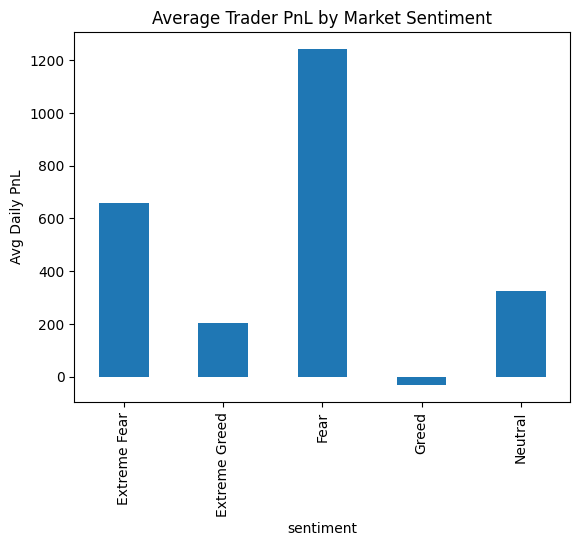

In [9]:
import matplotlib.pyplot as plt

avg_pnl = agg.groupby('sentiment')['daily_pnl'].mean()
avg_pnl.plot(kind='bar', title="Average Trader PnL by Market Sentiment")
plt.ylabel("Avg Daily PnL")
plt.show()


Representation of what does Profit & Loss look like on a daily basis for each trader with different sentiment

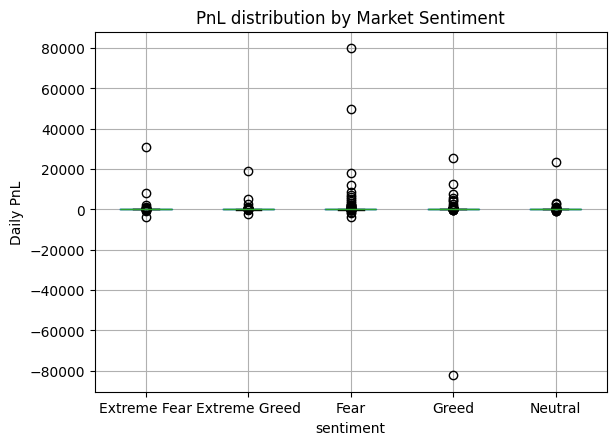

In [10]:
agg.boxplot(column='daily_pnl', by='sentiment')
plt.ylabel("Daily PnL")
plt.title("PnL distribution by Market Sentiment")
plt.suptitle("")
plt.show()


How different profit is on Fear Days and Greed Days

In [11]:
from scipy.stats import ttest_ind

fear = agg.loc[agg.sentiment=="Fear", "daily_pnl"]
greed = agg.loc[agg.sentiment=="Greed", "daily_pnl"]

t_stat, p_value = ttest_ind(fear, greed, equal_var=False, nan_policy='omit')
print(f"T-stat: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference in PnL between Fear and Greed days")
else:
    print("No significant difference in PnL between Fear and Greed days")

if t_stat > 0:
    print("Higher PnL on Fear days")
else:
    print("Higher PnL on Greed days")


T-stat: 1.6718294640638263, P-value: 0.09552719284093547
No significant difference in PnL between Fear and Greed days
Higher PnL on Fear days


In [12]:
total_pnl = agg['daily_pnl'].sum()
pnl_no_fear = agg.loc[agg.sentiment!="Fear", 'daily_pnl'].sum() #Greed + Neutral Days

print("Total PnL (all days):", total_pnl)
print("Total PnL (no Fear days):", pnl_no_fear)


Total PnL (all days): 307063.955415
Total PnL (no Fear days): 103270.674775


Cleaned Data

In [13]:
trades.to_csv("cleaned_trades_with_sentiment.csv", index=False)
agg.to_csv("trader_daily_summary.csv", index=False)
